In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, DenseNet121, DenseNet201, ResNet152
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, Reshape, Layer, Lambda,Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from keras.metrics import AUC
from sklearn.model_selection import train_test_split
# !pip install tensorflow-addons
import scipy as sp
from keras.layers import LayerNormalization
from warnings import warn as warnings_warn
import warnings
import glob
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras.applications import ResNet50, EfficientNetB0
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import Sequence
import math
import shutil
from tensorflow_addons.activations import gelu
import matplotlib.pyplot as plt

In [2]:
# # Define directory and image dimensions
# data_dir = '/kaggle/input/adni-jpg/dataset'
# img_width = 224
# img_height = 224
# batch_size = 2

# # Define data generators for training and validation sets
# data_generator = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2)

# train_generator = data_generator.flow_from_directory(
#     data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training')

# val_generator = data_generator.flow_from_directory(
#     data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation')

# # Get number of samples and steps per epoch for training and validation sets
# num_train_samples = len(train_generator.filenames)
# num_val_samples = len(val_generator.filenames)
# num_classes = len(train_generator.class_indices)

# train_steps_per_epoch = np.ceil(num_train_samples / batch_size)
# val_steps_per_epoch = np.ceil(num_val_samples / batch_size)

# print('Number of classes:', num_classes)
# print('Number of training samples:', num_train_samples)
# print('Number of validation samples:', num_val_samples)

# print('Steps per epoch for training set:', train_steps_per_epoch)
# print('Steps per epoch for validation set:', val_steps_per_epoch)

In [3]:
# # Set the directories for the data
# data_dir = "/kaggle/input/train-test-adni/dataset"
# train_dir = os.path.join(data_dir, "train")
# val_dir = os.path.join(data_dir, "val")

# # Create data generators
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)
# auc_metric = AUC(name='auc', multi_label=True)

# train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16, class_mode="categorical")
# val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=16, class_mode="categorical")


In [4]:
# Define directory and image dimensions
data_dir = '/kaggle/input/adni-jpg/dataset'
img_width = 224
img_height = 224

# Define data generators for training and validation sets
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    subset='training')

val_generator = data_generator.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 1372 images belonging to 3 classes.
Found 342 images belonging to 3 classes.


In [5]:
class Dummy_Input(tf.keras.layers.Layer):
    """
    This is the class for a 'classification token' mentioned in the ViT Paper
    
    @inproceedings{50650,
    title	= {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
    author	= {Alexander Kolesnikov and Alexey Dosovitskiy and Dirk Weissenborn and Georg Heigold and Jakob Uszkoreit and Lucas Beyer and Matthias Minderer and Mostafa Dehghani and Neil Houlsby and Sylvain Gelly and Thomas Unterthiner and Xiaohua Zhai},
    year	= {2021}
    }

    This adds a dummy input to an input layer which acts as a placeholder data structure that’s used to store information 
    that is extracted from other tokens in the sequence. 
    
    By allocating an empty token for this procedure, it seems like the Vision Transformer makes 
    it less likely to bias the final output towards or against any single one of the other individual tokens.  
    """
    def build(self, input_dimensions):
        self.dummy_val = self.add_weight(name="dummy_input",
                                         shape=(1, 1, input_dimensions[-1]), 
                                         initializer=tf.zeros_initializer(),
                                         trainable=True,)

    def call(self, inputs):
        dummy_val_token = tf.tile(self.dummy_val, 
                                  [tf.shape(inputs)[0], 1, 1])
        return tf.concat([dummy_val_token, 
                          inputs], axis=1)

class Inherit_Positional_Embeddings(tf.keras.layers.Layer):
    """
    In Vision Transformers, the input data is typically a 2D image that is flattened into a sequence of patches, which are then fed into the transformer model. 
    Since transformers do not inherently model positional information, additional positional embeddings are added to the input sequence in this code 
    to enable the model to take into account the spatial relationships between the patches.
    """

    def build(self, input_shape):
        self.learned_positional_embeddings = tf.Variable(name="pos_embedding",
                                                         initial_value=tf.initializers.random_normal(stddev=0.06)(shape=(1, input_shape[1], input_shape[2])),
                                                         dtype="float32", 
                                                         trainable=True,)
    def call(self, inputs):
        return inputs + self.learned_positional_embeddings

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    """
    From, 
        
    @inproceedings{50650,
    title	= {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
    author	= {Alexander Kolesnikov and Alexey Dosovitskiy and Dirk Weissenborn and Georg Heigold and Jakob Uszkoreit and Lucas Beyer and Matthias Minderer and Mostafa Dehghani and Neil Houlsby and Sylvain Gelly and Thomas Unterthiner and Xiaohua Zhai},
    year	= {2021}
    }
    
    Multihead self-attention (MSA) is an extension of SA in which we run k self-attention operations,
    called “heads”, in parallel, and project their concatenated outputs. 
    
    MSA(z) = [SA1(z); SA2(z); · · · ; SAk(z)]Umsa  
    where, Umsa ∈ R k·Dh×D is a learnable weight matrix. Credits to faustomorales the author or vit-keras for simplification of MultiHeadSelfAttention in his library.
    
    """
    def __init__(self, *args, num_heads, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        num_heads = self.num_heads
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // num_heads
        self.query = tf.keras.layers.Dense(hidden_size, name="query")
        self.key = tf.keras.layers.Dense(hidden_size, name="key")
        self.value = tf.keras.layers.Dense(hidden_size, name="value")
        self.combine_heads = tf.keras.layers.Dense(hidden_size, name="out")

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)
        query = tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])
        key = tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])
        value = tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tf.keras.layers.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, num_heads, mlp_dim, dropout, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            num_heads=self.num_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0",
                ),
                tf.keras.layers.Lambda(
                    lambda x: gelu(x, approximate=False)
                )
                if hasattr(tf.keras.activations, "gelu")
                else tf.keras.layers.Lambda(
                    lambda x: gelu(x, approximate=False)
                ),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tf.keras.layers.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout_layer(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

In [6]:
def get_correspondence(model):
    for transformer_id in range(12):
        encoder = model.get_layer(f"Transformer/encoderblock_{transformer_id}")
        source_prefix = f"Transformer/encoderblock_{transformer_id}"
        yield from get_norm_layer_correspondence(encoder, source_prefix)
        yield from get_mlp_block_correspondence(encoder, source_prefix)
        yield from get_attention_correspondence(encoder, source_prefix)

    for layer_name in ["pre_logits", "head","embedding"]:
        if layer_name == "head":
            continue
        yield {
            "layer": model.get_layer(layer_name),
            "keys": [f"{layer_name}/{name}" for name in ["kernel", "bias"]],
        }
    yield {"layer": model.get_layer("dummy_input"), "keys": ["cls"]}
    yield {
        "layer": model.get_layer("Transformer/encoder_norm"),
        "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
    }

def get_norm_layer_correspondence(encoder, source_prefix):
    return [
        {
            "layer": layer,
            "keys": [f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]],
        }
        for norm, layer in [
            ("LayerNorm_0", encoder.layernorm1),
            ("LayerNorm_2", encoder.layernorm2),
        ]
    ]

def get_mlp_block_correspondence(encoder, source_prefix):
    return [
        {
            "layer": encoder.mlpblock.get_layer(f"{source_prefix}/Dense_{mlpdense}"),
            "keys": [
                f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                for name in ["kernel", "bias"]
            ],
        }
        for mlpdense in [0, 1]
    ]

def get_attention_correspondence(encoder, source_prefix):
    return [
        {
            "layer": layer,
            "keys": [
                f"{source_prefix}/MultiHeadDotProductAttention_1/{value_temp}/{name}"
                for name in ["kernel", "bias"]
            ],
            "reshape": True,
        }
        for value_temp, layer in [
            ("query", encoder.att.query),
            ("key", encoder.att.key),
            ("value", encoder.att.value),
            ("out", encoder.att.combine_heads),
        ]
    ]

In [7]:
def load_ViT_model_with_weights(): 
    x = Input(shape=(224, 224, 3)) 
    y = Conv2D(filters=768, kernel_size=32,strides=32,padding="valid", name="embedding",)(x)
    y = Reshape((y.shape[1] * y.shape[2], 768))(y)
    y = Dummy_Input(name="dummy_input")(y)
    y = Inherit_Positional_Embeddings(name="Transformer/posembed_input")(y)
    
    for n in range(12):
        y, _ = TransformerBlock(
            num_heads=12,
            mlp_dim=3072,
            dropout=0.1,
            name=f"Transformer/encoderblock_{n}",
        )(y)
        
    y = tf.keras.layers.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm")(y)
    y = tf.keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(y)
    y = Dense(768, name="pre_logits", activation="tanh")(y)
    
    model = Model(inputs=x, outputs=y)
 
    
    fname = "ViT-B_32.npz"
    origin = f"https://storage.googleapis.com/vit_models/imagenet21k/{fname}"


    load_weights = np.load(tf.keras.utils.get_file(fname, origin, cache_subdir="weights"), allow_pickle=False)
    source_keys = list(load_weights.keys())
    print(source_keys)


    correspondence = list(get_correspondence(model))
    model.get_layer("Transformer/posembed_input").set_weights([load_weights["Transformer/posembed_input/pos_embedding"]])

    source_keys_used = []
    for match in correspondence:
        source_keys_used.extend(match["keys"])
        load_weights_values = [load_weights[k] for k in match["keys"]]
        if match.get("reshape", False):
            load_weights_values = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    load_weights_values, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(load_weights_values)

    
     
    return model

In [8]:
load_vit = load_ViT_model_with_weights()

419441810/419441810 [==============================] - 12s 0us/step
['Transformer/encoder_norm/bias', 'Transformer/encoder_norm/scale', 'Transformer/encoderblock_0/LayerNorm_0/bias', 'Transformer/encoderblock_0/LayerNorm_0/scale', 'Transformer/encoderblock_0/LayerNorm_2/bias', 'Transformer/encoderblock_0/LayerNorm_2/scale', 'Transformer/encoderblock_0/MlpBlock_3/Dense_0/bias', 'Transformer/encoderblock_0/MlpBlock_3/Dense_0/kernel', 'Transformer/encoderblock_0/MlpBlock_3/Dense_1/bias', 'Transformer/encoderblock_0/MlpBlock_3/Dense_1/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/kernel', 'Transformer/encoderbloc

In [9]:
top_layers = tf.keras.models.Sequential([
    Flatten(),   
    BatchNormalization(),
    Dense(64, activation = gelu),
    Dropout(0.2),
    BatchNormalization(),
    Dense(16, activation = gelu),
    
    BatchNormalization(),
    Dense(3, 'softmax')
], name='modified_vit_top')

# Combine the ViT model with the top layers
model = Sequential([
    load_vit,
    top_layers
], name='modified_vit')


# Define the optimizer and loss function
learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compile the model with metrics
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [11]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_auc_3',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [12]:
history = model.fit(
    train_generator,
    epochs=400,
    validation_data=val_generator,
    callbacks=[checkpoint_callback])

Epoch 1/400
86/86 [==============================] - 47s 246ms/step - loss: 1.5236 - accuracy: 0.3331 - auc: 0.5155 - val_loss: 1.0928 - val_accuracy: 0.4737 - val_auc: 0.5884
Epoch 2/400
86/86 [==============================] - 17s 198ms/step - loss: 1.4412 - accuracy: 0.3557 - auc: 0.5266 - val_loss: 1.0350 - val_accuracy: 0.4825 - val_auc: 0.6597
Epoch 3/400
86/86 [==============================] - 17s 202ms/step - loss: 1.3770 - accuracy: 0.3746 - auc: 0.5423 - val_loss: 1.5209 - val_accuracy: 0.2982 - val_auc: 0.5653
Epoch 4/400
86/86 [==============================] - 17s 200ms/step - loss: 1.3418 - accuracy: 0.3805 - auc: 0.5512 - val_loss: 1.4638 - val_accuracy: 0.2456 - val_auc: 0.4029
Epoch 5/400
86/86 [==============================] - 18s 205ms/step - loss: 1.3117 - accuracy: 0.3557 - auc: 0.5271 - val_loss: 1.1708 - val_accuracy: 0.3304 - val_auc: 0.5034
Epoch 6/400
86/86 [==============================] - 18s 209ms/step - loss: 1.2821 - accuracy: 0.3571 - auc: 0.5364 - va

In [13]:
model.save('vit2d_single_modal.h5')

In [145]:
y_true = []
y_pred = []

num_train_samples = len(train_generator.filenames)
num_val_samples = len(val_generator.filenames)
num_classes = len(train_generator.class_indices)

num_train_samples, num_val_samples, num_classes

(1372, 342, 3)

In [146]:
for X_batch, y_batch in val_generator :
    y_true.extend(y_batch)
    y_pred.extend(model.predict(X_batch))

    if len(y_true) >= num_val_samples:
        break

y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_true_array, axis=1)
y_pred = np.argmax(y_pred_array, axis=1)

1/1 [==============================] - 0s 106ms/step


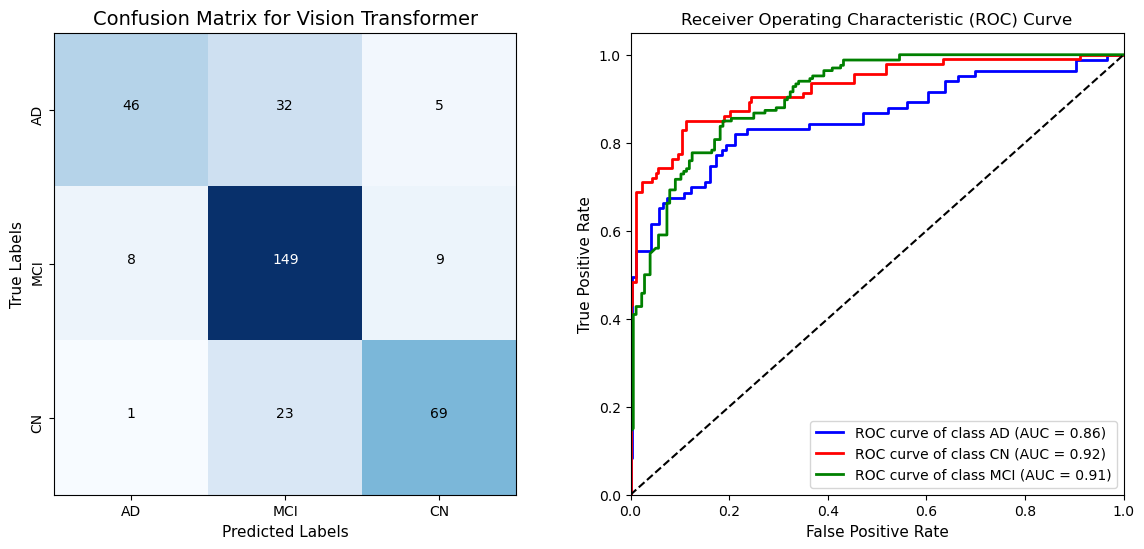

In [147]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(14, 6))

class_labels = ['AD', 'MCI', 'CN']  # Rearranged class labels
rearranged_indices = [0, 2, 1]

cm = confusion_matrix(y_true, y_pred)
cm = cm[rearranged_indices][:, rearranged_indices]
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Vision Transformer', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=11)
plt.ylabel('True Labels', fontsize=11)

tick_marks = np.arange(3)
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels, rotation=90)
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_array[:,i], y_pred_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
class_labels2 = ['AD', 'CN', 'MCI']

plt.subplot(122)
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {class_labels2[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2)
plt.savefig('2d_vit.png', bbox_inches='tight')